In [1]:
!pip install gensim
!pip install huggingface_hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from wordcloud import WordCloud
from collections import Counter

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import time
import requests


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


stop_words= stopwords.words("english")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
song_1 = '''
When you walk through a storm
Hold your head up high
And don't be afraid of the dark
At the end of a storm
There's a golden sky
And the sweet silver song of a lark

[Pre-Chorus]
Walk on through the wind
Walk on through the rain
Though your dreams be tossed and blown

[Chorus]
Walk on, walk on
With hope in your heart
And you'll never walk alone
You'll never walk alone
Walk on, walk on
With hope in your heart
And you'll never walk alone
You'll never walk alone'''

song_2 = '''Let's go!
Steve walks warily down the street
With the brim pulled way down low
Ain't no sound but the sound of his feet
Machine guns ready to go
Are you ready? Hey, are you ready for this?
Are you hanging on the edge of your seat?
Out of the doorway, the bullets rip
To the sound of the beat, yeah
Another one bites the dust
Another one bites the dust
And another one gone, and another one gone
Another one bites the dust (yeah)
Hey, I'm gonna get you, too
Another one bites the dust
How do you think I'm gonna get along
Without you, when you're gone?
You took me for everything that I had
And kicked me out on my own
Are you happy, are you satisfied?
How long can you stand the heat?
Out of the doorway, the bullets rip
To the sound of the beat, look out
Another one bites the dust
Another one bites the dust
And another one gone, and another one gone
Another one bites the dust
Hey, I'm gonna get you too
Another one bites the dust
Hey!
Oh, take it
Bite the dust
Bite the dust, hey
Hey
Another one bites the dust
Another one bites the dust, ow!
Another one bites the dust, hey, hey
Another one bites the dust, hey
Ooh, shout!
There are plenty of ways that you can hurt a man
And bring him to the ground
You can beat him, you can cheat him, you can treat him bad
And leave him when he's down, yeah
But I'm ready, yes I'm ready for you
I'm standing on my own two feet
Out of the doorway, the bullets rip
Repeating to the sound of the beat, oh yeah
Another one bites the dust
Another one bites the dust
And another one gone, and another one gone
Another one bites the dust, yeah
Hey, I'm gonna get you too
Another one bites the dust
Shoot out
Ay-yeah
Alright'''

song_3 = '''So close, no matter how far
Couldn't be much more from the heart
Forever trusting who we are
And nothing else matters
Never opened myself this way
Life is ours, we live it our way
All these words, I don't just say
And nothing else matters
Trust I seek and I find in you
Every day for us something new
Open mind for a different view
And nothing else matters
Never cared for what they do
Never cared for what they know
But I know
So close, no matter how far
It couldn't be much more from the heart
Forever trusting who we are
And nothing else matters
Never cared for what they do
Never cared for what they know
But I know
I never opened myself this way
Life is ours, we live it our way
All these words, I don't just say
And nothing else matters
Trust I seek and I find in you
Every day for us something new
Open mind for a different view
And nothing else matters
Never cared for what they say
Never cared for games they play
Never cared for what they do
Never cared for what they know
And I know, yeah, yeah
So close, no matter how far
Couldn't be much more from the heart
Forever trusting who we are
No, nothing else matters'''

text = [song_1, song_2, song_3]
text

["\nWhen you walk through a storm\nHold your head up high\nAnd don't be afraid of the dark\nAt the end of a storm\nThere's a golden sky\nAnd the sweet silver song of a lark\n\n[Pre-Chorus]\nWalk on through the wind\nWalk on through the rain\nThough your dreams be tossed and blown\n\n[Chorus]\nWalk on, walk on\nWith hope in your heart\nAnd you'll never walk alone\nYou'll never walk alone\nWalk on, walk on\nWith hope in your heart\nAnd you'll never walk alone\nYou'll never walk alone",
 "Let's go!\nSteve walks warily down the street\nWith the brim pulled way down low\nAin't no sound but the sound of his feet\nMachine guns ready to go\nAre you ready? Hey, are you ready for this?\nAre you hanging on the edge of your seat?\nOut of the doorway, the bullets rip\nTo the sound of the beat, yeah\nAnother one bites the dust\nAnother one bites the dust\nAnd another one gone, and another one gone\nAnother one bites the dust (yeah)\nHey, I'm gonna get you, too\nAnother one bites the dust\nHow do you

Text preprocessing: lowercasing, lemmatizing, stopwords removal, tokienization
* we have removed words like [chorus], [verse], ...
* we replace all the capital letters sby non capital
* we remove all the next line characters and convert all the all the contractions like "don't" -> "do not", "I'm" -> "I am"
* we remove all the punctuation
* we split text by tokens, remove all stopwords and lemmatize them

in result we get fully cleaned and prepared list of 3 lists of tokens ready for vectorization

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# remove words like [chorus], [verse], ...
text = [re.sub(r"\[.*?\]", "", data) for data in text]

# make all letters noncapital
text = [txt.lower() for txt in text];
#print(f'{text[0]}\n{text[1]}\n{text[2]}')

cleaned_text = []
# remove '\n', punctuation, ''re', ''m', ''ll', ''s', 'n't'
punctuation = r'[,.!?/():;\'-]'
contractions = { "can't": "cannot", "won't": "will not", "couldn't": "could not",
    "there's" : "there is", "shouldn't": "should not", "wouldn't": "would",
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not",
    "weren't": "were not", "haven't": "have not", "hasn't": "has not",
    "hadn't": "had not", "mustn't": "must not", "ain't" : "is not",
    "i'm" : "i am", "you'll" : "you will", "you're" : "you are"
}

for txt in text:
    txt = re.sub(r'\n', ' ', txt)
    for contraction, replacement in contractions.items():
        txt = re.sub(re.escape(contraction), replacement, txt)
    txt = re.sub(punctuation, ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    cleaned_text.append(txt)
text = cleaned_text

processed_txt = []
for txt in text:
    tokens = txt.split()
    filtered_tokens = []
    for token in tokens:
        lem = lemmatizer.lemmatize(token)
        if lem not in stop_words and lem.strip() != ' ':
            filtered_tokens.append(lem)
    processed_txt.append(' '.join(filtered_tokens))

text = processed_txt
print(f'text 1 : {text[0]}\ntext 2 : {text[1]}\ntext 3 : {text[2]}')

text 1 : walk storm hold head high afraid dark end storm golden sky sweet silver song lark walk wind walk rain though dream tossed blown walk walk hope heart never walk alone never walk alone walk walk hope heart never walk alone never walk alone
text 2 : let go steve walk warily street brim pulled way low sound sound foot machine gun ready go ready hey ready hanging edge seat doorway bullet rip sound beat yeah another one bite dust another one bite dust another one gone another one gone another one bite dust yeah hey gonna get another one bite dust think gonna get along without gone took everything kicked happy satisfied long stand heat doorway bullet rip sound beat look another one bite dust another one bite dust another one gone another one gone another one bite dust hey gonna get another one bite dust hey oh take bite dust bite dust hey hey another one bite dust another one bite dust ow another one bite dust hey hey another one bite dust hey ooh shout plenty way hurt man bring grou

### Lets compute TF-IDF and analyse its matrix


as we can see, we got the tf-idf values. Accoring to our calculations, we got the most important words in each song, meaning these word are the most important in these texts (documents):
* Song 0:
  * walk: 0.7526
  * alone: 0.3599
  * never: 0.2737

* Song 1:
  * another: 0.4957
  * one: 0.4957
  * dust: 0.4056

* Song 2:
  * matter: 0.4483
  * cared: 0.3586
  * never: 0.3409

We can notice that in the top 3 of the most important words in each song are in the chorus. There is no wonder, since I have chosen quite different songs with different vocabulary and the most frequent words in each song (they are in the chorus that is repeated several times) aren't often met in other songs (corpus).

In [4]:
tfidf = TfidfVectorizer()
tf_idf_matrix = tfidf.fit_transform(text)
features = tfidf.get_feature_names_out()

df = pd.DataFrame(tf_idf_matrix.toarray(), columns=features)
correlation_matrix = df.corr()

for i in range(df.shape[0]):
    print(f"Song {i} top 3 words:")
    top_words = df.iloc[i].sort_values(ascending=False).head(3)
    for word, score in top_words.items():
        corr = correlation_matrix[word].sort_values(ascending=False).drop(word).head(3)
        print(f"  {word}: {score:.4f}")

    print()

Song 0 top 3 words:
  walk: 0.7526
  alone: 0.3599
  never: 0.2737

Song 1 top 3 words:
  another: 0.4957
  one: 0.4957
  dust: 0.4056

Song 2 top 3 words:
  matter: 0.4483
  cared: 0.3586
  never: 0.3409



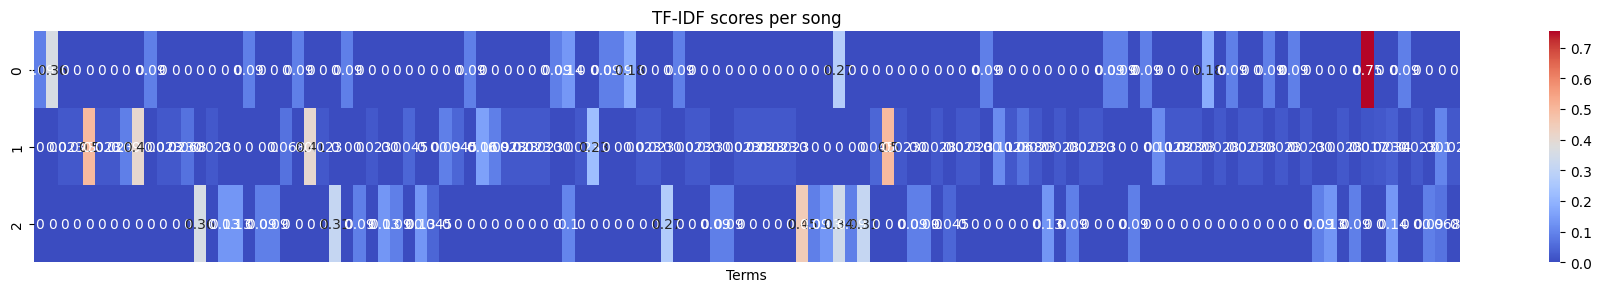

In [5]:
plt.figure(figsize=(23, 3))
sns.heatmap(df, annot=True, cmap='coolwarm', xticklabels=False)
plt.title('TF-IDF scores per song')
plt.xlabel('Terms')
plt.show()

### Compare TF-IDF with other text vectorization methods, such as Count Vectorizer, Word2Vec, or Doc2Vec

Time comparison for 3 vectoriser methods
* CountVectorizer
* TF-IDF
* Word2Vec
* Doc2Vec

and record the execution times in seconds

In [6]:
methods = ['CountVectorizer', 'TF-IDF', 'Word2Vec', 'Doc2Vec']
execution_times = {}
fitted_models = {}

def run_vectorizer(text, execution_times, fitted_models):
    start = time.time()
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(text)
    end = time.time()
    execution_times['CountVectorizer'] = end - start
    fitted_models['CountVectorizer'] = (count_vec, count_matrix)

    start = time.time()
    tf_idf = TfidfVectorizer()
    tfifd_matrix = tf_idf.fit_transform(text)
    end = time.time()
    execution_times['TF-IDF'] = end - start
    fitted_models['TF-IDF'] = (tf_idf, tfifd_matrix)

    tokenizer = [txt.split() for txt in text]
    start = time.time()
    word2vec_model = Word2Vec(sentences=tokenizer, vector_size=100, window=5, min_count=1, workers=4)
    end = time.time()
    execution_times['Word2Vec'] = end - start
    fitted_models['Word2Vec'] = word2vec_model

    tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(text)]
    start = time.time()
    doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=6)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    end = time.time()
    execution_times['Doc2Vec'] = end - start
    fitted_models['Doc2Vec'] = doc2vec_model

    return execution_times, fitted_models

execution_times, fitted_models = run_vectorizer(text, execution_times, fitted_models)

for method in execution_times:
    print(f'{method} : {execution_times[method]:.5f} seconds')


CountVectorizer : 0.00293 seconds
TF-IDF : 0.00313 seconds
Word2Vec : 0.01452 seconds
Doc2Vec : 0.02046 seconds


As we can see such vectorizers as CountVectorizer and TF-IDF take much less time than Word2Vec. This might be due to the fact that Word2Vec and Doc2Vec are a neural network based embedding model, thus it takes much more time than other "classic" methods. Especially when the data amount increases.

Moreover, Doc2Vec learns not only on word vectors, but also on document vectors, also it has a parameter epochs, so it surely influences the training times by making it pass k times over the same data for that reason it might take even more time than word2vec, especially as the number of epochs increases

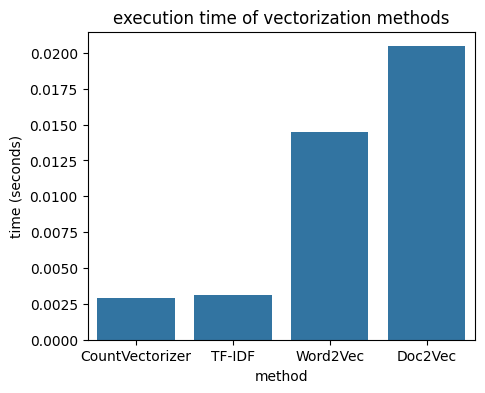

In [7]:
plt.figure(figsize=(5, 4))
sns.barplot(x = list(execution_times.keys()), y = list(execution_times.values()))
plt.title('execution time of vectorization methods')
plt.xlabel('method')
plt.ylabel('time (seconds)')
plt.show()

### Compare TF-IDF with other text vectorization methods, such as Count Vectorizer, Word2Vec, or Doc2Vec

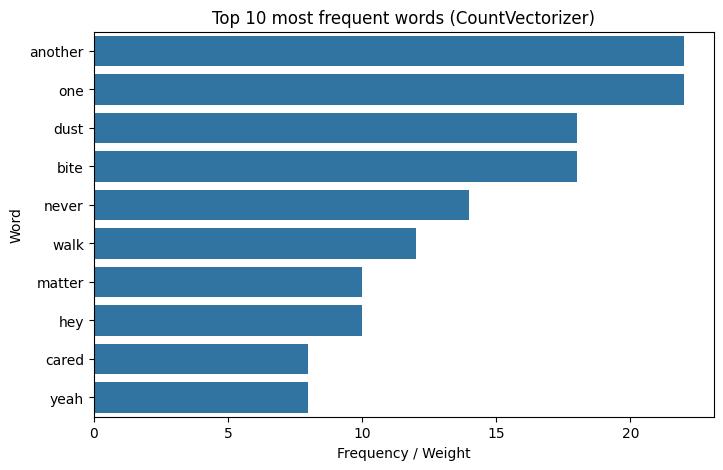

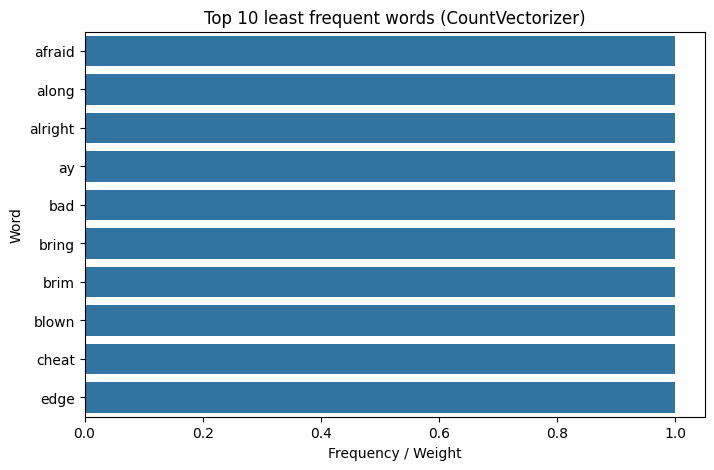

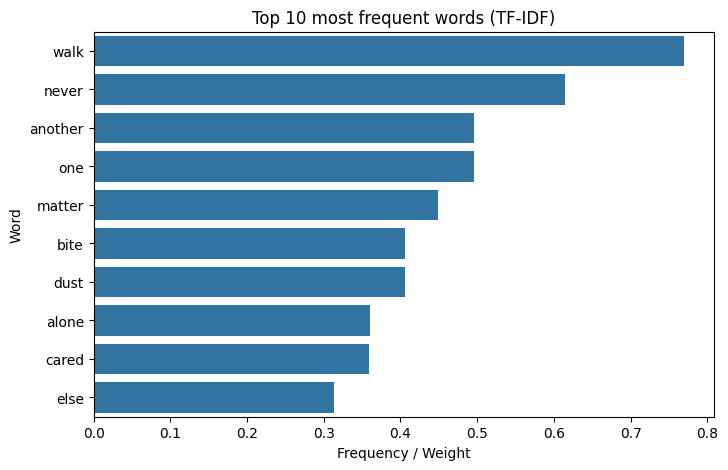

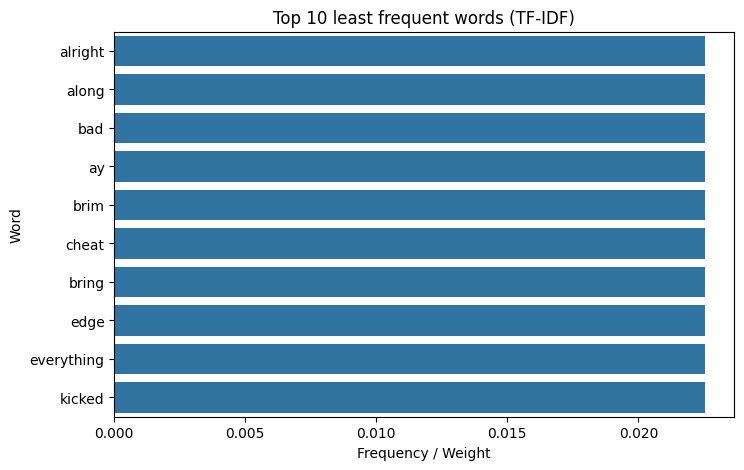

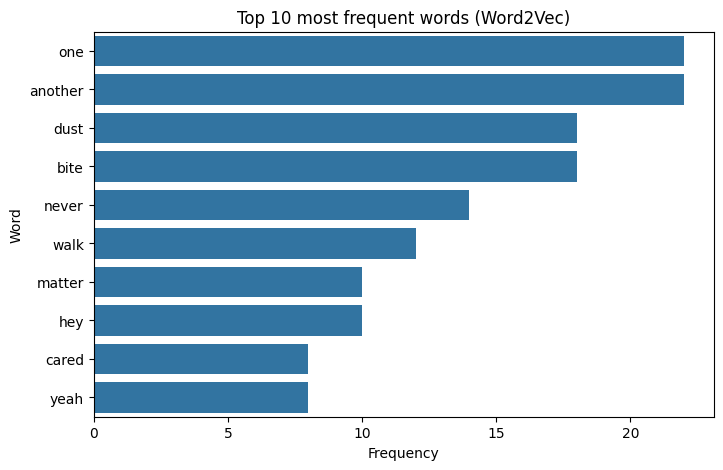

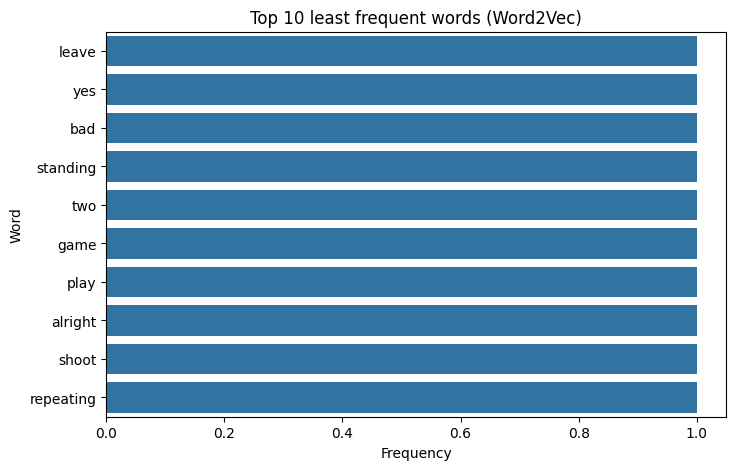

In [8]:
def plot_top_bottom_words(matrix, feature_names, method_name, n=10):
    word_counts = np.asarray(matrix.sum(axis=0)).flatten()
    df = pd.DataFrame({'word': feature_names, 'count': word_counts})

    df_top = df.sort_values('count', ascending=False).head(n)
    df_bottom = df[df['count'] > 0].sort_values('count', ascending=True).head(n)

    plt.figure(figsize=(8, 5))
    sns.barplot(y='word', x='count', data=df_top)
    plt.title(f'Top {n} most frequent words ({method_name})')
    plt.xlabel('Frequency / Weight')
    plt.ylabel('Word')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(y='word', x='count', data=df_bottom)
    plt.title(f'Top {n} least frequent words ({method_name})')
    plt.xlabel('Frequency / Weight')
    plt.ylabel('Word')
    plt.show()

def plot_top_bottom_words_w2v(model, method_name='Word2Vec', n=10):
    word_counts = [(word, model.wv.get_vecattr(word, "count")) for word in model.wv.index_to_key]
    df = pd.DataFrame(word_counts, columns=["word", "count"])

    df_top = df.sort_values('count', ascending=False).head(n)
    df_bottom = df[df['count'] > 0].sort_values('count', ascending=True).head(n)

    plt.figure(figsize=(8, 5))
    sns.barplot(y='word', x='count', data=df_top)
    plt.title(f'Top {n} most frequent words ({method_name})')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(y='word', x='count', data=df_bottom)
    plt.title(f'Top {n} least frequent words ({method_name})')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

count_vec, count_matrix = fitted_models['CountVectorizer']
plot_top_bottom_words(count_matrix, count_vec.get_feature_names_out(), "CountVectorizer")

tfidf_vec, tfidf_matrix = fitted_models['TF-IDF']
plot_top_bottom_words(tfidf_matrix, tfidf_vec.get_feature_names_out(), "TF-IDF")

w2v_model = fitted_models['Word2Vec']
plot_top_bottom_words_w2v(w2v_model, "Word2Vec")

We notice that:
* Count vectorizer:
    * **the most frequent words:** another, one, dust, bite, never, walk, metter, hey, cared, yeah
    * **least frequent words:** afraid, along, alright, ay, bad, bring, brim, blown, cheat, edge
* TF-IDF:
    * **the most frequent words:** walk, never, another, one, matter, bite, dust, alone, cared, else
    * **least frequent words:** alright, along, bad, ay, brim, cheat, bring, edge, everthing, kicked
* Word2vec:
    * **the most frequent words:** one, another, dust, bite, never, walk, matter, hey, cared, yeah
    * **least frequent words:** leave, yes, bad, standing, two, game, play, alright, shoot, repeating

Overall, the most frequent words are similar among all vectorizers, despite the fact that their positions slightly vary. Also, as before we will mention that the most frequent values are in the chorus and it's not surprising that they are the most frequent, since it's repeated multiple times.

Also, the least frequent sets of words are slightly similar for count vectorizer and TF-IDF, at least we have some intersections. However, for Word2vec the set of least frequent words are different, except some words. We can also notice that these tokens are often in verses.


### lets now consider bigrams

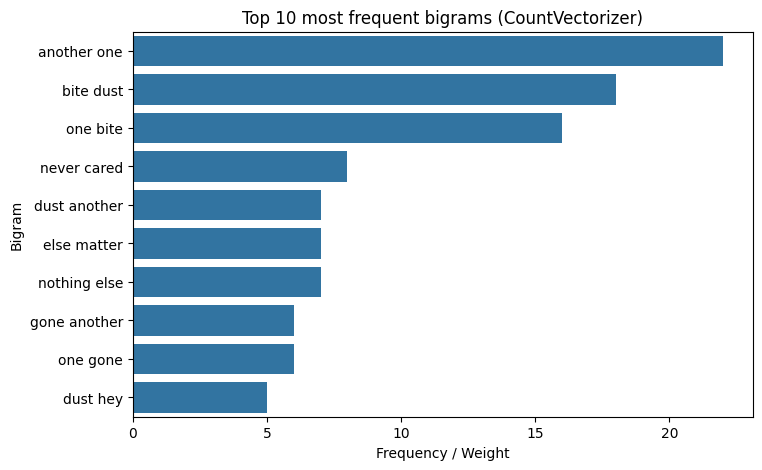

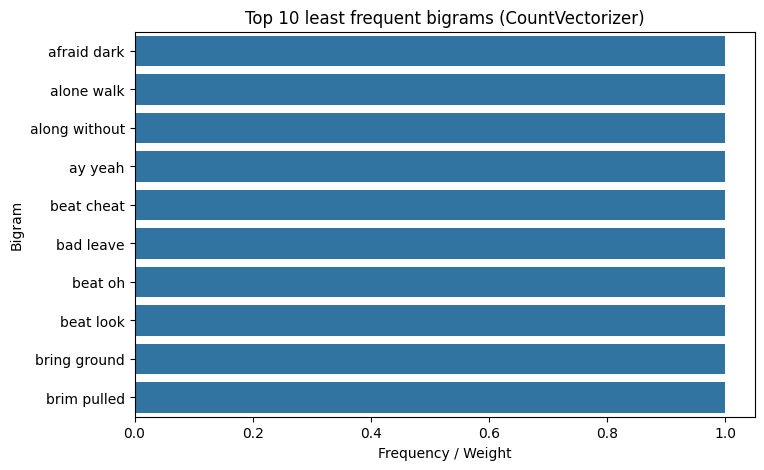

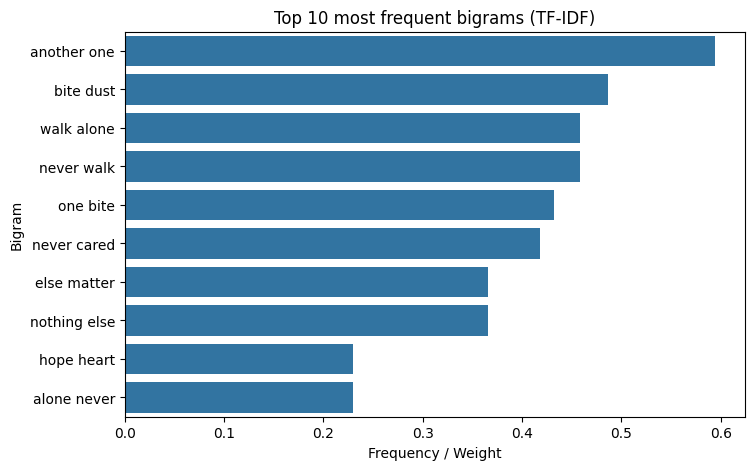

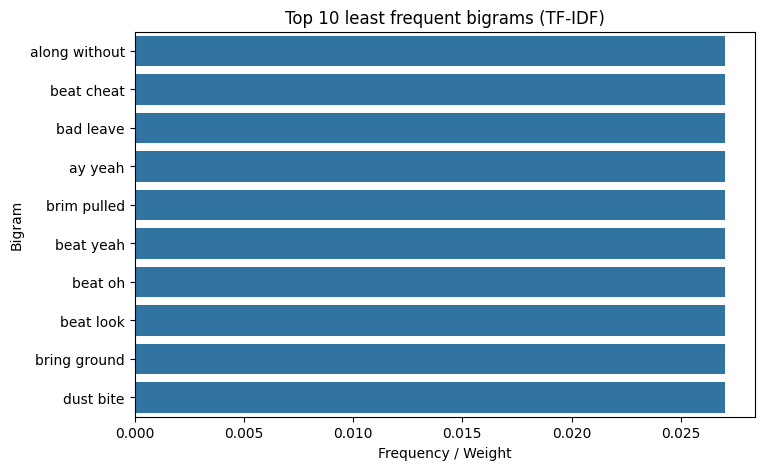

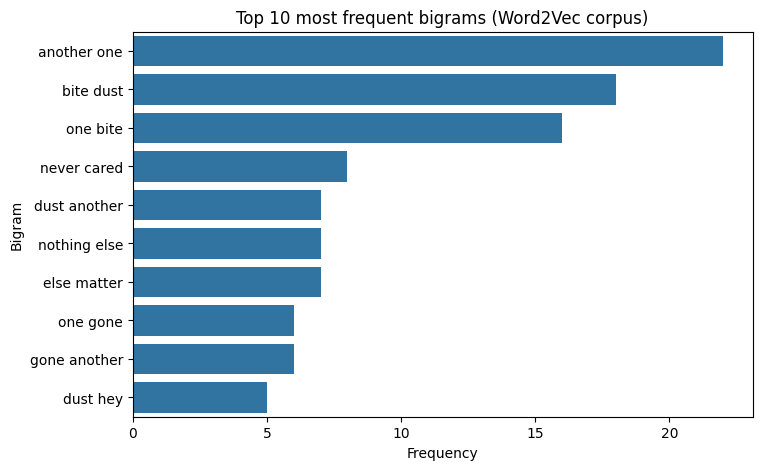

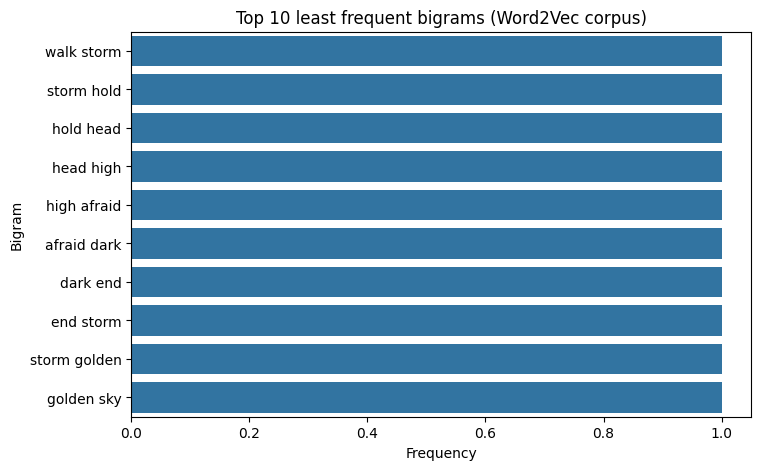

In [9]:
def plot_top_bottom_bigrams(vectorizer, text, method_name, n=10):

    matrix = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    counts = np.asarray(matrix.sum(axis=0)).flatten()
    df = pd.DataFrame({'bigram': feature_names, 'count': counts})

    df_top = df.sort_values('count', ascending=False).head(n)
    plt.figure(figsize=(8, 5))
    sns.barplot(y='bigram', x='count', data=df_top)
    plt.title(f'Top {n} most frequent bigrams ({method_name})')
    plt.xlabel('Frequency / Weight')
    plt.ylabel('Bigram')
    plt.show()

    df_bottom = df[df['count'] > 0].sort_values('count', ascending=True).head(n)
    plt.figure(figsize=(8, 5))
    sns.barplot(y='bigram', x='count', data=df_bottom)
    plt.title(f'Top {n} least frequent bigrams ({method_name})')
    plt.xlabel('Frequency / Weight')
    plt.ylabel('Bigram')
    plt.show()

def plot_top_bottom_bigrams_w2v(tokenized_text, n=10):

    bigrams = []
    for tokens in tokenized_text:
        bigrams.extend([(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)])

    bigram_counts = Counter(bigrams)
    df = pd.DataFrame(bigram_counts.items(), columns=['bigram','count'])
    df['bigram'] = df['bigram'].apply(lambda x: " ".join(x))

    df_top = df.sort_values('count', ascending=False).head(n)
    plt.figure(figsize=(8, 5))
    sns.barplot(y='bigram', x='count', data=df_top)
    plt.title(f'Top {n} most frequent bigrams (Word2Vec corpus)')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.show()

    df_bottom = df.sort_values('count', ascending=True).head(n)
    plt.figure(figsize=(8, 5))
    sns.barplot(y='bigram', x='count', data=df_bottom)
    plt.title(f'Top {n} least frequent bigrams (Word2Vec corpus)')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.show()

count_vec_bigram = CountVectorizer(ngram_range=(2,2))
plot_top_bottom_bigrams(count_vec_bigram, text, method_name="CountVectorizer", n=10)

tfidf_vec_bigram = TfidfVectorizer(ngram_range=(2,2))
plot_top_bottom_bigrams(tfidf_vec_bigram, text, method_name="TF-IDF", n=10)

tokenizer = [t.split() for t in text]
plot_top_bottom_bigrams_w2v(tokenizer, n=10)

We notice that:
* Count vectorizer:
    * **the most frequent bigrams:** another one, bite dust, one bite, never cared, dust another, else matter, nothing else, gone another
    * **least frequent bigrams:** afraid dark, alone walk, ah yeah, beat cheat, bad leave, beat oh, beat oh
* TF-IDF:
    * **the most frequent bigrams:** another one, bite dust, walk alone, never walk, one bite, never cared, else matter, nothing else
    * **least frequent bigrams:** along without, beat cheat, bad leave, ay yeah, brim pulled, beat yeah, beat oh, beat look
* Word2vec:
    * **the most frequent bigrams:** another one, bite dust, one bite, never cared, dust another, nothing else, else matter, one gone
    * **least frequent bigrams:** walk storm, storm hold, hold head, head high, high afraid, dark end, end storm, storm golden.

Overall, the most frequent bigrams are similar among all vectorizers, despite the fact that their positions slightly vary. Also, as before we will mention that the most frequent bigrams and the most frequent words from previous analysis step form these most popular bigrams, also they are in the chorus and it's not surprising that they are the most frequent, since it's repeated multiple times.

Also, the least frequent bigrams are similar for count vectorizer and TF-IDF, at least we have some intersections. However, for Word2vec the set of least frequent words are different, except some words in the bigrams. We can also notice that these tokens are often in verses.

### t-SNE for vectorisers

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


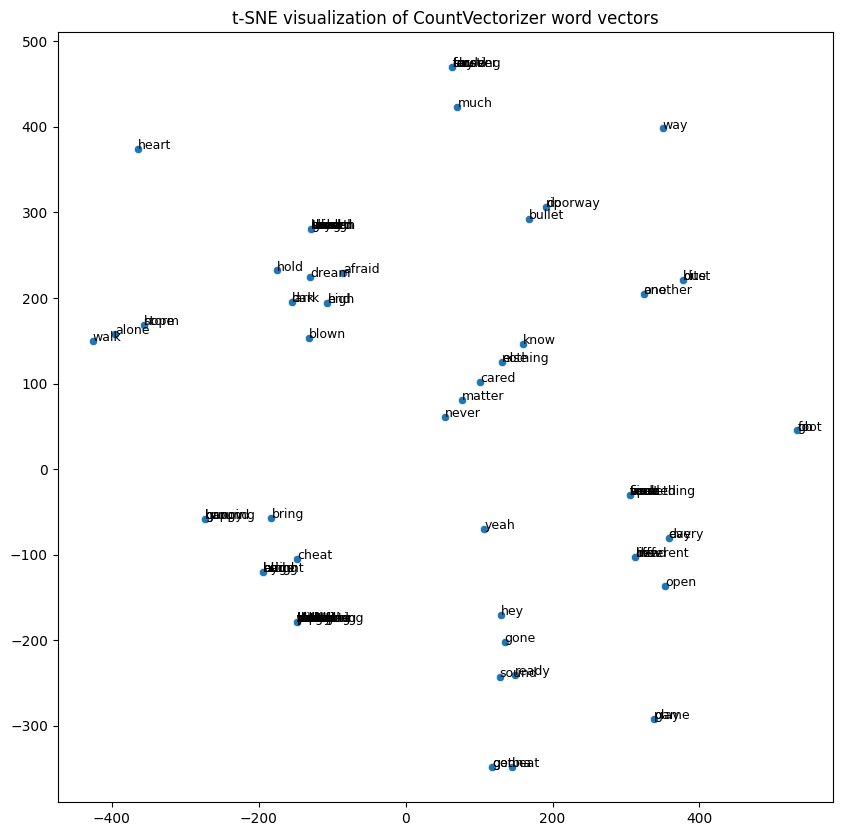

In [10]:
# CountVectorizer
count_vec, count_matrix = fitted_models['CountVectorizer']

X_words = count_matrix.T.toarray()
words = count_vec.get_feature_names_out()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=1000)
X_embedded = tsne.fit_transform(X_words)

plt.figure(figsize=(10,10))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1])

for i, word in enumerate(words):
    plt.text(X_embedded[i,0], X_embedded[i,1], word, fontsize=9)

plt.title("t-SNE visualization of CountVectorizer word vectors")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


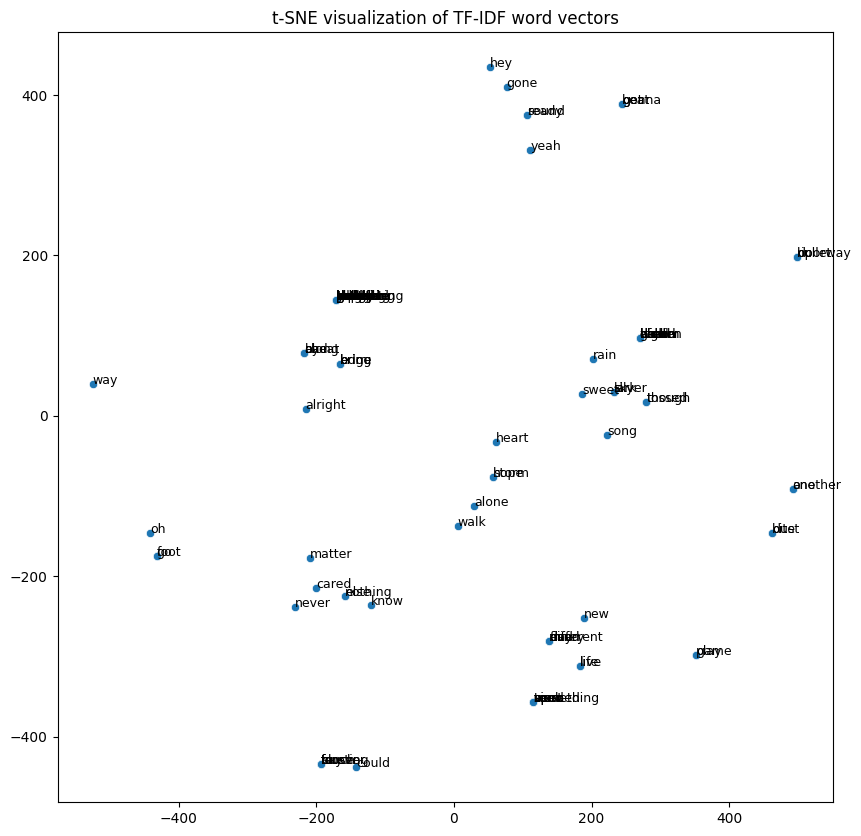

In [11]:
# TF-IDF
X_words = tfidf_matrix.T.toarray()
words = tfidf_vec.get_feature_names_out()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=1000)
X_embedded = tsne.fit_transform(X_words)

plt.figure(figsize=(10,10))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1])

for i, word in enumerate(words):
    plt.text(X_embedded[i,0], X_embedded[i,1], word, fontsize=9)

plt.title("t-SNE visualization of TF-IDF word vectors")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


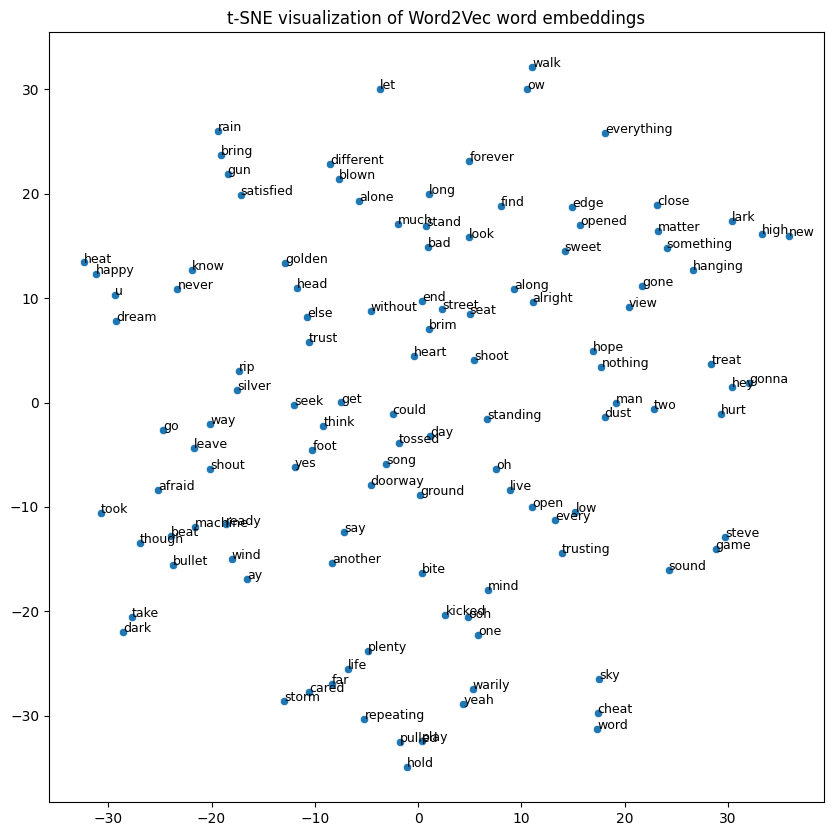

In [12]:
# Word2Vec t-SNE
w2v_model = fitted_models['Word2Vec']

words = list(w2v_model.wv.index_to_key)
X_words = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
X_embedded = tsne.fit_transform(X_words)

plt.figure(figsize=(10,10))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1])

for i, word in enumerate(words):
    plt.text(X_embedded[i,0], X_embedded[i,1], word, fontsize=9)

plt.title("t-SNE visualization of Word2Vec word embeddings")
plt.show()

After visualising the embeddings using t_SNE, we can notice that TF-IDF and Count vectorizer have similar clusters that are quite dense, like for example:
* matter, cared, never, know, else, nothing
* afraid, alone, blown, dark, dream, end, golden, head, high, hold, hope, ark, rain, silver, sky, song, storm, sweet, though, tossed, wind
* sound, ready, go, yeah, hey, gone
It means that hey are more likely to occure together.

the t-SNE clusters for Word2vec seem to be less separated

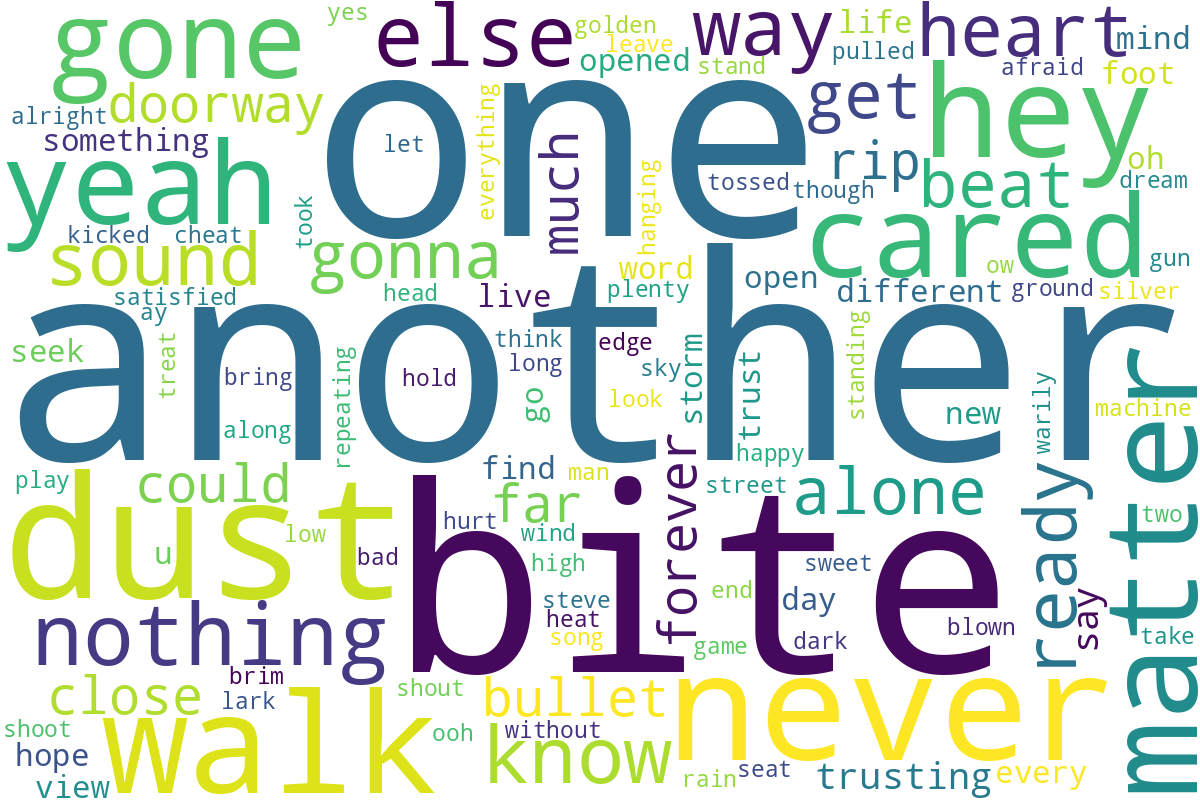

In [13]:
full_text = ''
for txt in text:
    full_text = full_text + txt + ' '

tokens = full_text.split(" ")
word_counts = Counter(tokens)

cloud = WordCloud(width=1200, height=800, background_color = '#FFFFFF')
cloud.generate_from_frequencies(word_counts)
cloud.to_image()

From the full text we can see that such words as "another", "bite", "one", "dust", "never", "walk", "gone", "cared" are the most frequent words in the text.

## Part BERT

In [14]:
!pip install transformers

In [15]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from transformers import BertModel
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.metrics import accuracy_score, roc_curve, auc

In [16]:
df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
df.loc[0, 'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Data preprocessing

* In target variables we will replace labels positive with 1 and negative with 0
* for tokenization we will preprocess our data by:
    * delete HTML tags
    * lowercase the text
    * remove '\n'
    * remove punctuation
    * tokenize by split
    * remove stopwords

In [18]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [19]:
lemmatizer = WordNetLemmatizer()

punctuation_pattern = r'[,.!?/():;\'"\-]'

def text_preprocessing(text, to_list=False):
    text = re.sub(r"<.*?>", " ", text) # remove HTML tags
    text = text.lower() # lowercase
    text = re.sub(r"\n", " ", text) # remove '\n'
    text = re.sub(punctuation_pattern, " ", text) # remove punctuation
    # tokenize using split (preserve spaces)
    tokens = re.split(r" |/|-", text)
    # remove stopwords
    clean_tokens = [tok for tok in tokens if tok and tok.strip() != "" and tok not in stop_words ]
    # return list or string (spaces preserved)
    return clean_tokens if to_list else " ".join(clean_tokens)

In [20]:
df['processed_review'] = df['review'].apply(lambda x: text_preprocessing(x, to_list=False))

In [21]:
df.loc[0, 'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [22]:
df.loc[0, 'processed_review']

'one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street ski

since our data preprocessing looks good, we will now pass to the tokenization, but first we will split our data by train, test and validation dataframes.

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_data(data, tokenizer, max_len=256):
    return tokenizer(data.tolist() if hasattr(data, 'tolist') else data,
                     add_special_tokens=True, max_length=max_len,
                     padding='max_length', truncation=True,
                     return_attention_mask=True, return_tensors='pt')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
first_review = df["processed_review"].iloc[0]
encoding = tokenize_data(first_review, tokenizer, 128)

print(f"train input id: {encoding['input_ids'][0]}\n"
      f"train input attention_mask: {encoding['attention_mask'][0]}\n"
      f"decoded: {tokenizer.decode(encoding['input_ids'][0])}")

train input id: tensor([  101,  2028, 15814,  3855,  3666,  1015, 11472,  2792, 13322,  2157,
         3599,  3047,  2034,  2518,  4930, 11472, 24083,  4895, 10258,  2378,
         8450,  5019,  4808,  2275,  2157,  2773,  2175,  3404,  2265,  8143,
        18627,  5199,  3593,  2265,  8005, 17957, 12362,  5850,  3348,  4808,
        13076,  4438,  2224,  2773,  2170, 11472,  8367,  2445, 17411,  4555,
         3036,  2110,  7279,  4221, 12380,  2854,  7679,  3701, 14110,  2103,
         6388,  2930,  3827,  4442,  3221, 21430,  2227, 20546,  2015,  9394,
         2152, 11376,  7861,  2103,  2188,  2116, 26030,  2015,  7486, 18542,
        10230,  7402,  2015,  8135, 16773,  3493,  8040, 16093, 28331,  2331,
        14020, 26489,  6292, 24069, 22824, 10540,  2196,  2521,  2185,  2052,
         2360,  2364,  5574,  2265,  2349,  2755,  3632,  3065,  8108,  5293,
         3492,  4620,  4993,  7731,  9501,  5293, 11084,  5293,  7472, 11472,
         6752,  2105,  2034,  2792,  2412,  2387

In [25]:
X = df['processed_review']
Y = df['sentiment']

X_train, X_t, Y_train, Y_t = train_test_split(X, Y, test_size=0.6, random_state=42)

X_valid, X_test, Y_valid, Y_test = train_test_split(X_t, Y_t, test_size=0.5, random_state=42)

print(f"shape X_train: {X_train.shape}\nshape X_test: {X_test.shape}\nshape X_validation: {X_valid.shape}")

shape X_train: (20000,)
shape X_test: (15000,)
shape X_validation: (15000,)


In [26]:
train_encoding = tokenize_data(X_train, tokenizer)
valid_encoding = tokenize_data(X_valid, tokenizer)
test_encoding  = tokenize_data(X_test, tokenizer)

train_labels = torch.tensor(Y_train.values)
valid_labels = torch.tensor(Y_valid.values)
test_labels  = torch.tensor(Y_test.values)

In [27]:
BATCH_SIZE = 8

# create tensordatasets
train_dataset = TensorDataset(train_encoding["input_ids"], train_encoding["attention_mask"], train_labels)
valid_dataset = TensorDataset(valid_encoding["input_ids"], valid_encoding["attention_mask"], valid_labels)
test_dataset = TensorDataset(test_encoding["input_ids"], test_encoding["attention_mask"], test_labels)

# dataloaders
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset),batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

In [28]:
class BertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", freeze_bert=False):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
        return logits

In [29]:
epochs = 3
def initialize_model(epochs=epochs):
    model = BertClassifier(freeze_bert=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

    # total training steps
    total_steps = len(train_loader) * epochs

    # learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    return model, optimizer, scheduler, device

In [30]:
from tqdm import tqdm
loss_func = nn.CrossEntropyLoss()

def train(model, train_loader, valid_loader, optimizer, scheduler, device, epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # ---- Training ----
        model.train()
        total_train_loss = 0

        # Wrap train_loader with tqdm
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]

            optimizer.zero_grad()
            logits = model(b_input_ids, attention_mask=b_attn_mask)
            loss = loss_func(logits, b_labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ---- Validation ----
        model.eval()
        total_valid_loss = 0

        # Wrap valid_loader with tqdm
        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
                logits = model(b_input_ids, attention_mask=b_attn_mask)
                loss = loss_func(logits, b_labels)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.3f} | Validation Loss {avg_valid_loss:.3f}")

    return train_losses, valid_losses


In [31]:
model = BertClassifier(freeze_bert=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses, valid_losses = train(model, train_loader, valid_loader, optimizer, scheduler, device, epochs=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/3


Epoch 1: Train Loss 0.344 | Validation Loss 0.268

Epoch 2/3


Epoch 2: Train Loss 0.158 | Validation Loss 0.269

Epoch 3/3


Epoch 3: Train Loss 0.052 | Validation Loss 0.310


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [33]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]

            # Forward pass
            logits = model(b_input_ids, attention_mask=b_attn_mask)

            # Predictions
            batch_preds = torch.argmax(logits, axis=1).cpu().numpy()
            preds.extend(batch_preds)
            true_labels.extend(b_labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds)
    rec = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)

    print(f"Test Accuracy:  {acc:.3f}")
    print(f"Test Precision: {prec:.3f}")
    print(f"Test Recall:    {rec:.3f}")
    print(f"Test F1-score:  {f1:.3f}")

    return acc, prec, rec, f1

# Run evaluation
acc, prec, rec, f1 = evaluate_on_test(model, test_loader, device)

Test Accuracy:  0.907
Test Precision: 0.910
Test Recall:    0.905
Test F1-score:  0.907


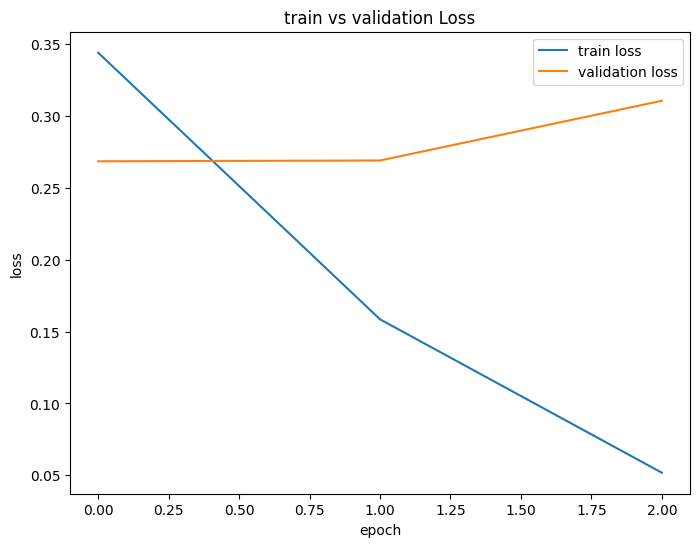

In [34]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train vs validation Loss")
plt.legend()
plt.show()

The model and the embedding take a lot of time to train, even for 3 epochs. But it's not too bad, since it's a neural network and we have several thousands of data examples. But the inference is much faster.

In conclusion, we can see that:
* accuraacy > 0.9 => takes over 90% samples correctlly
* precison > 0.9 => over 90% correct predictions of true positives
* recall > 0.9 => over 90% correctly finds the share of true positives
* f1 score are over 0. => precision and recall are both high and balanced.

Overall, despite the fact that we have only 3 epochs, we have managed to have a model with high prediction power. If we would have more epochs, we could get even more impressive score making validation error decrease and testing too.